## Tech Minds: Analyzing Mental Health Trends in Technology Professionals

In [1]:
# Data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from scipy.stats import randint
from sklearn.preprocessing import binarize
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

# Validation
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve, classification_report
from sklearn.model_selection import cross_val_score

Splitting the Dataset

In [31]:
import pandas as pd
from google.colab import drive

def load_data(data_filepath):
    """
    Loads the dataset from the given file path, splits it into features (X) and target (y),
    and returns the feature columns.

    Input:
        data_filepath (str): File path to the cleaned dataset (CSV file).

    Output:
        X (pd.DataFrame): Features for training.
        y (pd.Series): Target label.
        feature_cols (list): List of feature column names.
    """
    # Mount Google Drive
    drive.mount('/content/drive')

    # Load the dataset
    try:
        data = pd.read_csv(data_filepath)
    except FileNotFoundError:
        raise FileNotFoundError(f"The file '{data_filepath}' was not found.")
    except Exception as e:
        raise ValueError(f"Error loading the dataset: {e}")

    # Define feature columns
    feature_cols = [
        'Age', 'Gender', 'family_history', 'benefits', 'care_options',
        'anonymity', 'leave', 'work_interfere'
    ]

    # Validate that all required columns exist in the dataset
    missing_cols = [col for col in feature_cols + ['treatment'] if col not in data.columns]
    if missing_cols:
        raise ValueError(f"The following columns are missing from the dataset: {missing_cols}")

    # Split into features (X) and target (y)
    X = data[feature_cols]
    y = data['treatment']

    # Encode categorical variables (e.g., Gender)
    X = pd.get_dummies(X, columns=['Gender'], drop_first=True)
    # Update feature_cols to match the actual columns after encoding
    feature_cols = X.columns.tolist()

    return X, y, feature_cols
    return X, y, feature_cols

In [32]:
# Building a forest and checking features importance
def feature_importance(X, y, feature_cols):
  '''
  input:
      X: labels for training
      Y: target label
      feature_cols: features list
  output:
      None
  '''

  forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
  forest.fit(X, y)
  importance = forest.feature_importances_
  std = np.std([tree.feature_importances_ for tree in forest.estimators_],
              axis=0)
  indices = np.argsort(importance)[::-1]

  labels = []
  for f in range(X.shape[1]):
      labels.append(feature_cols[f])

  # Plotting important features
  plt.figure(figsize=(12,8))
  plt.title("Most Important Features")
  plt.bar(range(X.shape[1]), importance[indices],
        color="y", yerr=std[indices], align="center")
  plt.xticks(range(X.shape[1]), labels, rotation='vertical')
  plt.xlim([-1, X.shape[1]])
  plt.show();

# 4. Data Modelling

4.1 Model 1 : Logistic Regression

In [33]:
def logisticRegression(X_train, y_train, X_test, y_test, X, y):
    '''
      input:
          X_train: feature labels for training
          y_train: target label for training
          X_test: feature labels for test
          y_test: target label for test
          X: labels for training
          Y: target label
      output:
        None
    '''

    # train a logistic regression model on the training set
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)

    # make class predictions for the testing set
    y_pred_class = logreg.predict(X_test)

    accuracy_score = evaluate_model(logreg, y_test, y_pred_class, X, y)

    #Data for final graph
    methodDict['Log. Regres.'] = accuracy_score * 100

4.2 Model 2 : K - Nearest Neighbour Clasifier

In [34]:
def Knn(X_train, y_train, X_test, y_test, X, y):
    '''
      input:
          X_train: feature labels for training
          y_train: target label for training
          X_test: feature labels for test
          y_test: target label for test
          X: labels for training
          Y: target label
      output:
        None
      '''

    # Calculating the best parameters
    knn = KNeighborsClassifier(n_neighbors=5)

    # Defining the parameter values that should be searched
    k_range = list(range(1, 31))
    weight_options = ['uniform', 'distance']

    # Specifying "parameter distributions" rather than a "parameter grid"
    param_dist = dict(n_neighbors=k_range, weights=weight_options)
    tuningRandomizedSearchCV(knn, param_dist, X, y)

    # Training KNeighborsClassifier model on the training set
    knn = KNeighborsClassifier(n_neighbors=27, weights='uniform')
    knn.fit(X_train, y_train)

    # Making class predictions for the testing set
    y_pred_class = knn.predict(X_test)

    accuracy_score = evaluate_model(knn, y_test, y_pred_class, X, y)

    #Data for final graph
    methodDict['KNN'] = accuracy_score * 100

4.3 Model 3 : Random Forest Classifier

In [35]:
def randomForest(X_train, y_train, X_test, y_test, feature_cols, X, y):
    '''
      input:
          X_train: feature labels for training
          y_train: target label for training
          X_test: feature labels for test
          y_test: target label for test
          feature_cols: features_list
          X: labels for training
          Y: target label
      output:
        None
      '''

    # Calculating the best parameters
    forest = RandomForestClassifier(n_estimators = 20)

    featuresSize = feature_cols.__len__()
    param_dist = {"max_depth": [3, None],
              "max_features": randint(1, featuresSize),
              "min_samples_split": randint(2, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
    tuningRandomizedSearchCV(forest, param_dist, X, y)

    # Building and fitting
    forest = RandomForestClassifier(max_depth = None, min_samples_leaf=8, min_samples_split=2, n_estimators = 20, random_state = 1)
    my_forest = forest.fit(X_train, y_train)

    # Making class predictions for the testing set
    y_pred_class = my_forest.predict(X_test)

    accuracy_score = evaluate_model(my_forest, y_test, y_pred_class, X, y)

    #Data for final graph
    methodDict['R. Forest'] = accuracy_score * 100

4.4 Model 4 : Boosting

In [44]:
def boosting(X_train, y_train, X_test, y_test, X, y):
    '''
    input:
        X_train: feature labels for training
        y_train: target label for training
        X_test: feature labels for test
        y_test: target label for test
        X: labels for training
        Y: target label
    output:
        None
    '''

    # Building and fitting
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)
    boost = AdaBoostClassifier(estimator=clf, n_estimators=500)  # Use `estimator` instead of `base_estimator`
    boost.fit(X_train, y_train)

    # Making class predictions for the testing set
    y_pred_class = boost.predict(X_test)

    accuracy_score = evaluate_model(boost, y_test, y_pred_class, X, y)

    # Data for final graph
    methodDict['Boosting'] = accuracy_score * 100

4.5 Model 5 : Bagging

In [37]:
def bagging(X_train, y_train, X_test, y_test, X, y):
    '''
      input:
          X_train: feature labels for training
          y_train: target label for training
          X_test: feature labels for test
          y_test: target label for test
          X: labels for training
          Y: target label
      output:
        None
      '''

    # Building and fitting
    bag = BaggingClassifier(DecisionTreeClassifier(), max_samples=1.0, max_features=1.0, bootstrap_features=False)
    bag.fit(X_train, y_train)

    # Making class predictions for the testing set
    y_pred_class = bag.predict(X_test)

    accuracy_score = evaluate_model(bag, y_test, y_pred_class, X, y)

    #Data for final graph
    methodDict['Bagging'] = accuracy_score * 100

## 5. Model Evaluation

In [38]:
def evaluate_model(model, y_test, y_pred_class,X, y):
    '''
      input:
          model: model to be evaluated
          y_test: target label for test
          y_pred_class: classes predicted by that model
          X: labels for training
          Y: target label
      output:
          accuracy: accuracy of the evaluated model
      '''

    # Confusion matrix
    confusion = metrics.confusion_matrix(y_test, y_pred_class)

    # Saving values
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    # Visualizing Confusion Matrix
    print('\n')
    sns.heatmap(confusion,annot=True,fmt="d")
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification Accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    print('\033[1m'+'\nClassification Accuracy:', accuracy)

    # AUC Score
    print('\033[1m'+'\nAUC Score:', metrics.roc_auc_score(y_test, y_pred_class))

    # Cross-validated AUC
    print('\033[1m'+'Cross-validated AUC:', cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean(), '\n')

    print('\033[1m'+'Classification Report:\n', classification_report(y_test, y_pred_class))

    return accuracy

Tuning the Model with RandomSearchCV

In [39]:
def tuningRandomizedSearchCV(model, param_dist, X, y):
    '''
      input:
          model: model for random search CV
          param_dist: dictionary of parameters and their values to be searched
          X: labels for training
          Y: target label
      output:
        None
      '''

    # n_iter controls the number of searches
    rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
    rand.fit(X, y)
    rand.cv_results_

    # Examining the best model
    print('\nRandomized Search Best Score: ', rand.best_score_)
    print('Randomized Search Best Parameters: ', rand.best_params_)

    # Run RandomizedSearchCV 20 times (with n_iter=10) and Record the best score
    best_scores = []
    for _ in range(20):
        rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10)
        rand.fit(X, y)
        best_scores.append(round(rand.best_score_, 3))
    print(best_scores)

Saving the Best Model and Predictions

In [40]:
# Saving best model results
def save_model(X, y, X_test):
  '''
      input:
          X: labels for training
          Y: target label
          X_test: feature labels for test
      output:
        None
      '''
  # Generating predictions with the best method
  clf = AdaBoostClassifier()
  clf.fit(X, y)
  dfTestPredictions = clf.predict(X_test)

  # Writing predictions to csv file
  results = pd.DataFrame({'Index': X_test.index, 'Treatment': dfTestPredictions})

  # Saving to file
  results.to_csv('results.csv', index=False)

In [41]:
 # Creating dictionaries for final graph
methodDict = {}
rmseDict = ()

In [42]:
def main():
    # Set the file path to the dataset in Google Drive
    data_filepath = '/content/drive/MyDrive/Datasets/data_for_modelling.csv'

    print('Loading data...\n')
    X, y, feature_cols = load_data(data_filepath)

    print('Plotting features in order of their importance..')
    feature_importance(X, y, feature_cols)

    # Split X and y into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

    # Model 1
    print('\033[94m'+'\033[1m'+'Building model 1: Logistic Regression...'+'\033[0m')
    logisticRegression(X_train, y_train, X_test, y_test, X, y)

    # Model 2
    print('\n'+'\033[94m'+'\033[1m'+'Building model 2: k-Nearest Neighbors Classifier...'+'\033[0m')
    Knn(X_train, y_train, X_test, y_test, X, y)

    # Model 3
    print('\n'+'\033[94m'+'\033[1m'+'Building model 3: Random Forests Classifier...'+'\033[0m')
    randomForest(X_train, y_train, X_test, y_test, feature_cols, X, y)

    # Model 4
    print('\n'+'\033[94m'+'\033[1m'+'Building model 4: Boosting...'+'\033[0m')
    boosting(X_train, y_train, X_test, y_test, X, y)

    # Model 5
    print('\n'+'\033[94m'+'\033[1m'+'Building model 5: Bagging...'+'\033[0m')
    bagging(X_train, y_train, X_test, y_test, X, y)

    # Saving the best model results in a file
    print('Saving model...')
    save_model(X, y, X_test)
    print('Trained model saved!')

Loading data...

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Plotting features in order of their importance..


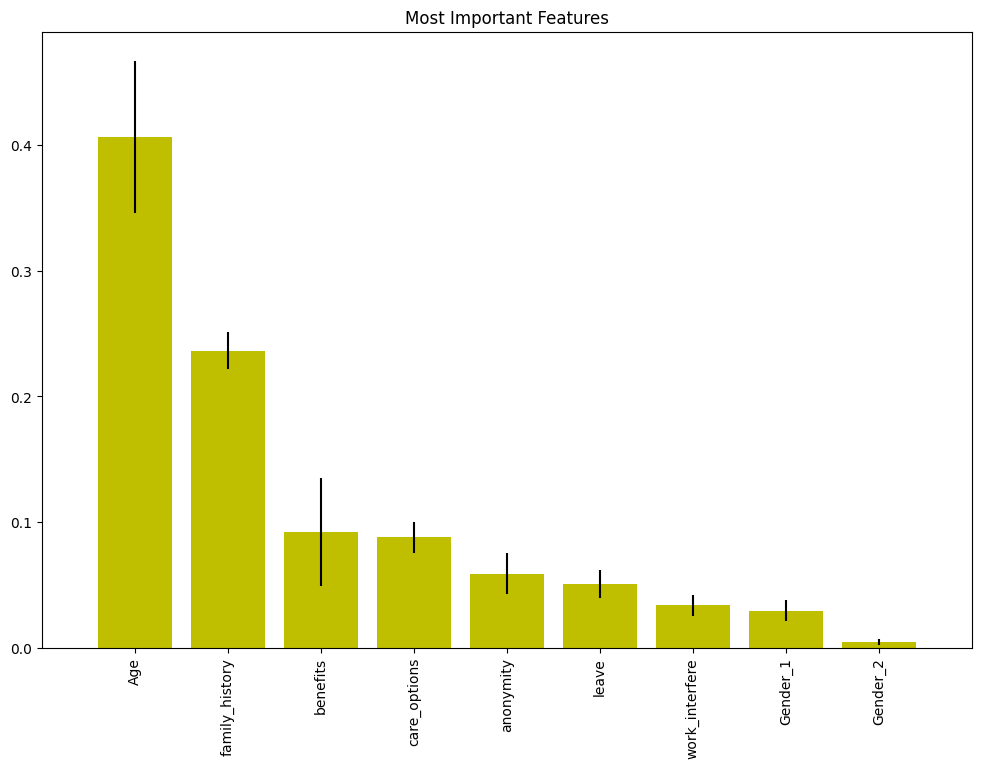

Building model 1: Logistic Regression...




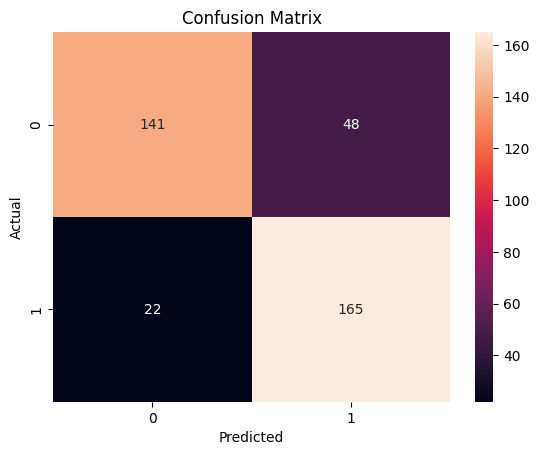


Classification Accuracy: 0.8138297872340425

AUC Score: 0.8141923436041083
Cross-validated AUC: 0.876173173495802 

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.75      0.80       189
           1       0.77      0.88      0.82       187

    accuracy                           0.81       376
   macro avg       0.82      0.81      0.81       376
weighted avg       0.82      0.81      0.81       376


Building model 2: k-Nearest Neighbors Classifier...

Randomized Search Best Score:  0.8172190476190476
Randomized Search Best Parameters:  {'weights': 'uniform', 'n_neighbors': 15}
[0.815, 0.818, 0.812, 0.816, 0.815, 0.818, 0.816, 0.816, 0.818, 0.808, 0.818, 0.815, 0.816, 0.81, 0.812, 0.815, 0.812, 0.818, 0.817, 0.814]




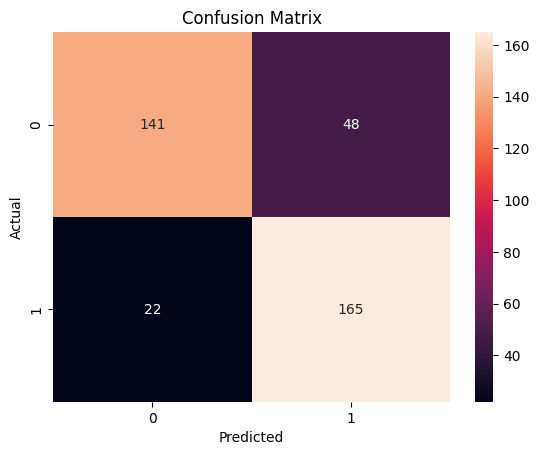


Classification Accuracy: 0.8138297872340425

AUC Score: 0.8141923436041083
Cross-validated AUC: 0.8780961854574565 

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.75      0.80       189
           1       0.77      0.88      0.82       187

    accuracy                           0.81       376
   macro avg       0.82      0.81      0.81       376
weighted avg       0.82      0.81      0.81       376


Building model 3: Random Forests Classifier...

Randomized Search Best Score:  0.8324063492063491
Randomized Search Best Parameters:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 8}
[0.83, 0.83, 0.83, 0.831, 0.83, 0.83, 0.833, 0.831, 0.833, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.832, 0.83, 0.833, 0.832]




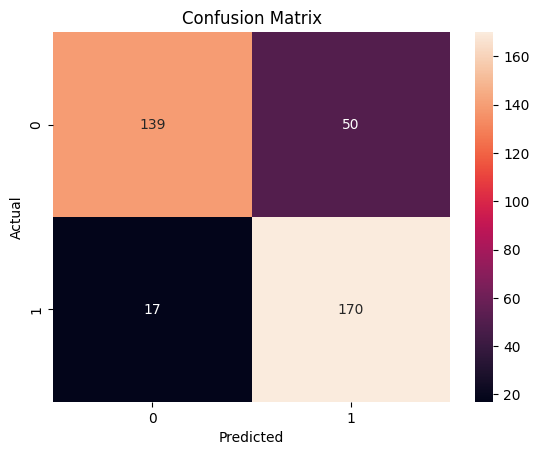


Classification Accuracy: 0.8218085106382979

AUC Score: 0.8222703222703224
Cross-validated AUC: 0.9011377648804443 

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.74      0.81       189
           1       0.77      0.91      0.84       187

    accuracy                           0.82       376
   macro avg       0.83      0.82      0.82       376
weighted avg       0.83      0.82      0.82       376


Building model 4: Boosting...




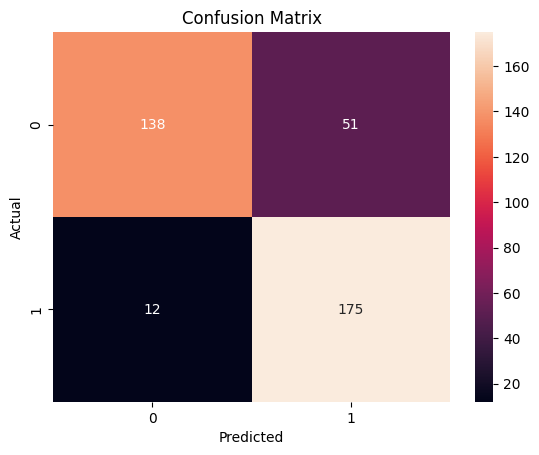


Classification Accuracy: 0.8324468085106383

AUC Score: 0.832993803582039
Cross-validated AUC: 0.8967415882870471 

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.73      0.81       189
           1       0.77      0.94      0.85       187

    accuracy                           0.83       376
   macro avg       0.85      0.83      0.83       376
weighted avg       0.85      0.83      0.83       376


Building model 5: Bagging...




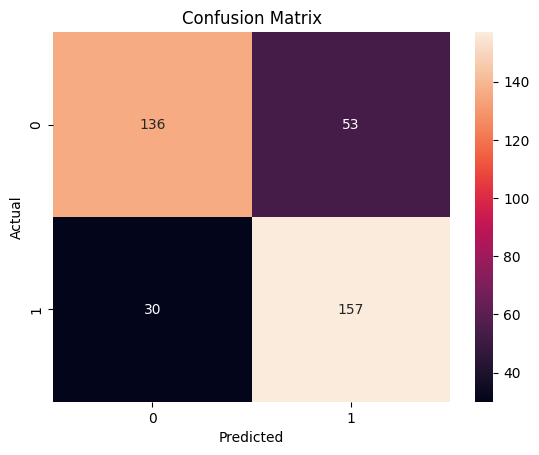


Classification Accuracy: 0.7792553191489362

AUC Score: 0.7795744560450443
Cross-validated AUC: 0.8427736232261722 

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.72      0.77       189
           1       0.75      0.84      0.79       187

    accuracy                           0.78       376
   macro avg       0.78      0.78      0.78       376
weighted avg       0.78      0.78      0.78       376

Saving model...
Trained model saved!


In [45]:
main()

In [46]:
def plotSuccess():
    s = pd.Series(methodDict)
    s = s.sort_values(ascending=False)
    plt.figure(figsize=(10,6))

    ax = s.plot(kind='bar', color=['grey', 'orange', 'lightgreen', 'yellow', 'cyan'], edgecolor='black')
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.ylim([70.0, 90.0])
    plt.xlabel('Model')
    plt.ylabel('Accuracy Percentage')
    plt.title('Models Performance ')

    plt.show()

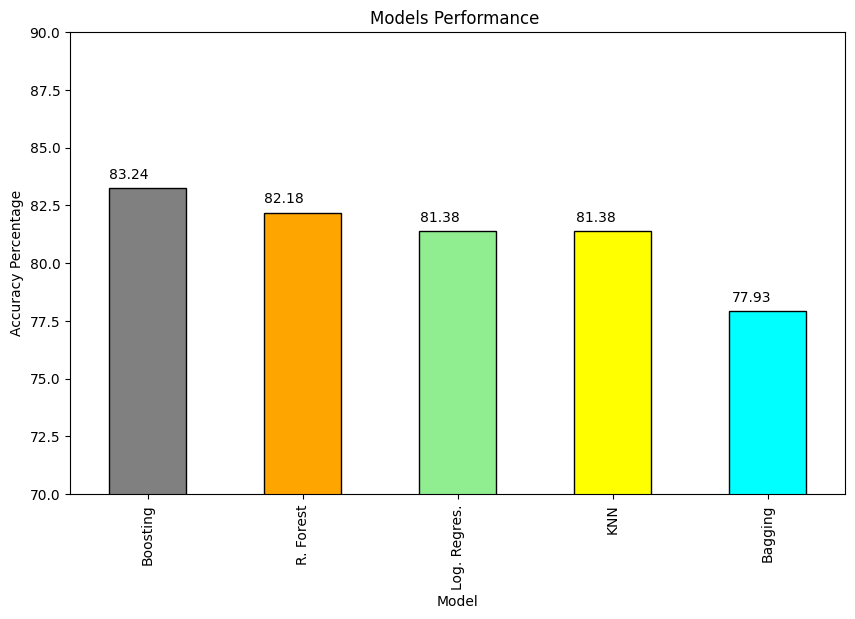

In [47]:
plotSuccess()